# Loading Packages

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk 
import string
import re
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
import spacy
from pprint import pprint
import matplotlib.colors as mcolors
from collections import Counter
from statsmodels.multivariate.manova import MANOVA


In [ ]:
#establishing SQL connection
import psycopg2
from getpass import getpass

# =================================
# == Database connection details ==
#==================================
host = '128.243.99.138' 
dbname = 'twitter' 
username = 'lixsn25' 
password = '@qxazPHG0' 
schema = 's' 
# =================================

In [ ]:
user = 'lixsn25'
db_ip = '128.243.99.138'
################################

pw = getpass('Enter the database password for {}: '.format(user))

In [ ]:
def get_dataset( ):
    sql = """
    SELECT *
    FROM s.final_tweets_updated
     """
    with psycopg2.connect("host='{}' dbname='twitter' user='{}' password='{}'".format(db_ip, user, pw)) as conn:
        df = pd.read_sql(sql, conn)
    
    return df

In [ ]:
tweets_data= get_dataset()

# Data Cleaning

In [ ]:
data = tweets_data.text.values.tolist()
data = [(' '.join(re.sub("(@[A-Za-z0-9_]+)|(http\S+)|(&amp)|(pic.\S+)|(#[A-Za-z0-9_]+)"," ",x).split())) for x in data]

In [ ]:
tweets_data=tweets_data.assign(tweets=data)

In [ ]:
#removing characters
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text=re.sub(r'http\S+', '', text)
    text = re.sub(r"\\[a-z][a-z]?[0-9]+", '', text)
    text= re.sub('[^A-Za-z ]+', '', text)
    return text

tweets_data['clean'] = tweets_data['tweets'].apply(lambda x: remove_punct(x))

In [ ]:
#Selecting subset of tweets randomly
sample_tweets=tweets_data.sample(n = 5000, random_state = 2)
sample_tweets.to_csv('sample_tweets.csv')

# Topic Modelling

In [ ]:
#loading sample tweets
sample_tweets pd.read_csv('sample_tweets.csv')

In [4]:
#converting into list
data = [(' '.join(re.sub("(@[A-Za-z0-9_]+)|(http\S+)|(&amp)|(pic.\S+)|(#[A-Za-z0-9_]+)"," ",x).split())) for x in data]

<>:1: DeprecationWarning: invalid escape sequence \S
<>:1: DeprecationWarning: invalid escape sequence \S
<>:1: DeprecationWarning: invalid escape sequence \S
<ipython-input-4-5fac8720fe0f>:1: DeprecationWarning: invalid escape sequence \S
  data = [(' '.join(re.sub("(@[A-Za-z0-9_]+)|(http\S+)|(&amp)|(pic.\S+)|(#[A-Za-z0-9_]+)"," ",x).split())) for x in data]


In [6]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [7]:
stop_words = ["amp", "coronavirus", "covid", "corona", "virus", "pandemic","will"] + list(STOPWORDS)

In [19]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


In [15]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_md", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['late', 'education', 'daily']]


In [527]:
#wordcloud
raw_string = ''.join(sample_tweets.text)
no_links = re.sub(r'http\S+', '', raw_string)
no_unicode = re.sub(r"\\[a-z][a-z]?[0-9]+", '', no_links)
no_special_characters = re.sub('[^A-Za-z ]+', '', no_unicode)
stop_words = ["amp", "coronavirus", "covid", "corona", "virus", "pandemic","will"] + list(STOPWORDS)
words = no_special_characters.split(" ")
words = [w for w in words if len(w) > 3]  # ignore a, an, be, ...
words = [w.lower() for w in words]
words = [w for w in words if w not in stop_words]

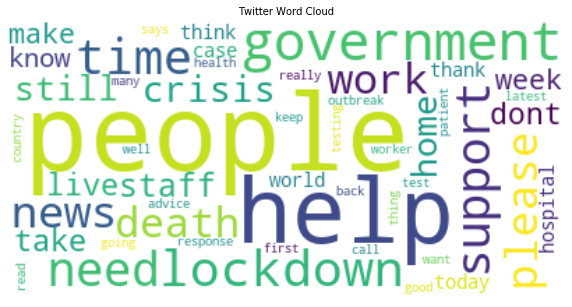

In [535]:
wc = WordCloud(background_color="white", max_words=50)
clean_string = ','.join(words)
wc.generate(clean_string)

f = plt.figure(figsize=(10,20))

plt.imshow(wc, interpolation='bilinear')
plt.title('Twitter Word Cloud', size=10)
plt.axis("off")
plt.show()


<FreqDist with 17230 samples and 59155 outcomes>


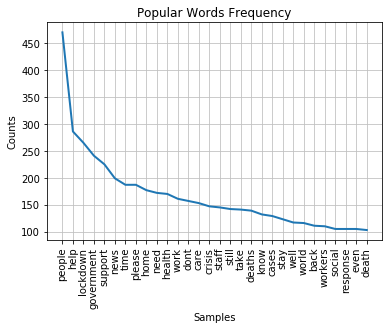

In [544]:
from nltk.probability import FreqDist
fdist = FreqDist(words)
print(fdist)
plt.title('Popular Words Frequency')
plt.xlabel('Words')
plt.ylabel('Frequency')
fdist.plot(30,cumulative=False)
plt.show()


In [20]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]



In [21]:
#tfidf
from gensim.models import TfidfModel
from gensim import models
tfidf =TfidfModel(corpus)

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1)]]


In [22]:
transformed_tfidf= tfidf[corpus]

In [ ]:
search_params = {'alpha': [0.01, 0.1, 0.2, 0.5, 0.8], 'eta': [0.01, 0.1, 0.2, 0.5, 0.8], 'passes':[10, 50, 100, 200], 'chunksize':[50, 100, 200, 300]}

In [251]:
#building lda model
lda_model = gensim.models.LdaMulticore(corpus=transformed_tfidf,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.01,
                                           eta=0.1)

In [137]:
def compute_coherence_value_final(dictionary, corpus, texts, limit, start=2, step=3):
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=transformed_tfidf,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.01,
                                           eta=0.1)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [138]:
# Can take a long time to run.
model_list_final, coherence_values_final = compute_coherence_value_final(dictionary=id2word, corpus=transformed_tfidf, texts=data_lemmatized, start=2, limit=40, step=6)

In [140]:
coherence_values_final

[0.5031518757066691,
 0.5369131192325756,
 0.528778894417257,
 0.5146477577025966,
 0.5347056400538988,
 0.4810055242549678,
 0.5421858420135781]

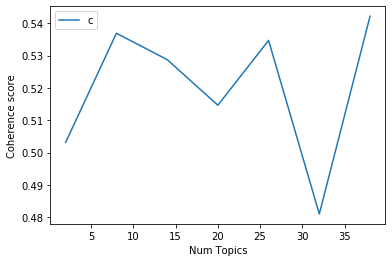

In [141]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values_final)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [254]:
from pprint import pprint
pprint(lda_model.print_topics())
doc_lda = lda_model[transformed_tfidf]

[(0,
  '0.013*"next" + 0.009*"join" + 0.007*"disease" + 0.006*"quarantine" + '
  '0.006*"likely" + 0.006*"d" + 0.005*"instead" + 0.005*"become" + '
  '0.005*"rest" + 0.004*"dominic_cumming"'),
 (1,
  '0.008*"death" + 0.007*"report" + 0.006*"least" + 0.006*"total" + '
  '0.005*"case" + 0.005*"apply" + 0.005*"possible" + 0.005*"rate" + '
  '0.005*"survey" + 0.005*"today"'),
 (2,
  '0.008*"fuck" + 0.007*"cope" + 0.006*"pension" + 0.006*"webinar" + '
  '0.005*"tackle" + 0.005*"mask" + 0.005*"confirmed_case" + 0.005*"enjoy" + '
  '0.004*"date" + 0.004*"count"'),
 (3,
  '0.008*"thank" + 0.008*"currently" + 0.007*"shut" + 0.007*"eye" + '
  '0.006*"turn" + 0.006*"refuse" + 0.006*"charity" + 0.006*"regard" + '
  '0.006*"scheme" + 0.005*"city"'),
 (4,
  '0.006*"family" + 0.005*"help" + 0.005*"be" + 0.005*"child" + '
  '0.004*"protect" + 0.004*"say" + 0.004*"take" + 0.004*"symptom" + '
  '0.004*"people" + 0.004*"include"'),
 (5,
  '0.010*"death" + 0.008*"people" + 0.008*"go" + 0.007*"die" + 0.007

In [252]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, transformed_tfidf, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.156030 -0.048252       1        1  22.917225
4     -0.141356  0.010293       2        1  21.931416
7     -0.132895  0.066728       3        1  17.783819
1      0.043793 -0.180586       4        1  10.124239
6      0.064095  0.128366       5        1   9.505104
0      0.098068  0.011204       6        1   7.010510
3      0.111990 -0.000562       7        1   6.295511
2      0.112335  0.012809       8        1   4.432176, topic_info=           Term       Freq      Total Category  logprob  loglift
286       death  46.000000  46.000000  Default  30.0000  30.0000
998        next  12.000000  12.000000  Default  29.0000  29.0000
46        thank  31.000000  31.000000  Default  28.0000  28.0000
728      report  17.000000  17.000000  Default  27.0000  27.0000
496        join   9.000000   9.000000  Default  26.0000  26.0000
...         ...        ...        ...      ...      ...      ...
33    brilliant   2.470586   5.190725   Topic8  -5.4997   2.3739
3918     choose   2.066574   3.483786   Topic8  -5.6783   2.5941
1530       wear   2.261081   5.131925   Topic8  -5.5883   2.2966
1085      write   2.412028   8.262590   Topic8  -5.5237   1.8850
772      demand   2.128772   6.118601   Topic8  -5.6486   2.0605

[442 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1939      7  0.762662   absolute
633       6  0.843126     accord
23        2  0.896489        act
777       6  0.830992     actual
124       1  0.115691     advice
...     ...       ...        ...
1200      1  0.975877      wrong
875       1  0.898324       year
875       8  0.074860       year
843       1  0.853082  yesterday
843       2  0.121869  yesterday

[713 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 8, 2, 7, 1, 4, 3])

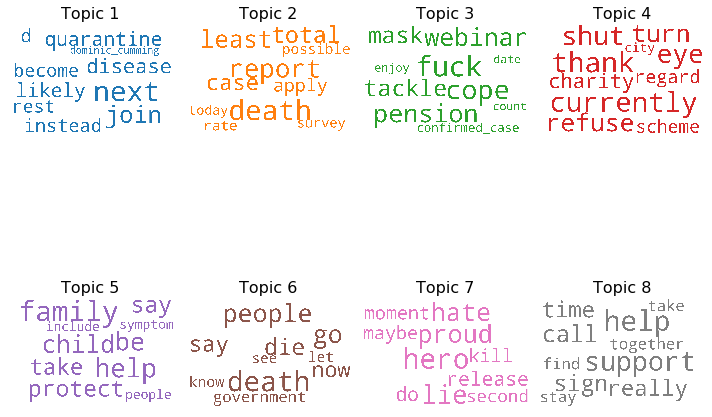

In [541]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=3000,
                  height=2000,
                  max_words=30,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False,num_topics=8)

fig, axes = plt.subplots(2, 4, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=500)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [186]:
# Finding the dominant topic in each sentence
optimal_model = model_list_final[2]
def format_topics_sentences(ldamodel=lda_model, corpus=transformed_tfidf, texts=data_lemmatized):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[transformed_tfidf]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = lda_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=transformed_tfidf, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.tail(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
4995,4995,5.0,0.9654,"go, people, death, work, know, government, die...",Coronavirus How does contact tracing work and ...
4996,4996,0.0,0.5727,"next, join, change, write, currently, disease,...",Can you RT please Would like to say a massive ...
4997,4997,4.0,0.7406,"say, family, help, take, people, now, together...",Today were launching Community Grants for comm...
4998,4998,5.0,0.7148,"go, people, death, work, know, government, die...",JUST IN Portugal reports new cases of coronavi...
4999,4999,7.0,0.5642,"support, school, sign, useful, stay, info, exa...",A message from during yesterdays show regardin...


In [253]:
df_dominant_topic.Dominant_Topic.value_counts()

4.0    1469
7.0    1098
5.0     847
0.0     454
1.0     374
6.0     351
3.0     230
2.0     177
Name: Dominant_Topic, dtype: int64

In [188]:
#Find the most representative document for each topic
# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf.head(8)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9813,"next, join, change, write, currently, disease,...",My latest features a lovable dog Zeffy a stray...
1,1.0,0.9805,"death, report, case, total, fund, least, staff...",SIX Premier League players and staff at three ...
2,2.0,0.9820,"begin, fuck, cope, lad, enjoy, webinar, animal...",We are aware cyber criminals and fraudsters ar...
3,3.0,0.9777,"thank, late, shut, eye, release, message, turn...",Todays Grant Shapps Q A at the Coronavirus had...
4,4.0,0.9850,"say, family, help, take, people, now, together...",What part of do not leave your home for any re...
5,5.0,0.9840,"go, people, death, work, know, government, die...",NEW Latest stats show deaths were recorded wit...
6,6.0,0.9825,"kill, hero, order, do, hate, proud, maybe, mom...",I want to buy some wee things from some small ...
7,7.0,0.9844,"support, school, sign, useful, stay, info, exa...",Anyone else stopped watching the UK Press Brie...


In [702]:
#findig representative tweets for topics
df_dominant_topic[df_dominant_topic.Dominant_Topic==6].Text[193]

'V bad situation facing universities gtgt Education hit hardest as coronavirus batters UK economy'

# Geo Analysis

In [ ]:
def geofinal( ):
    sql = """
    SELECT *
    FROM s.geofinal
     """
    with psycopg2.connect("host='{}' dbname='twitter' user='{}' password='{}'".format(db_ip, user, pw)) as conn:
        df = pd.read_sql(sql, conn)
    
    return df

In [ ]:
geofinal= geofinal()

In [ ]:
geo_final=geofinal.drop(columns=['location', 'rn'], axis=0)

In [255]:
geo_final.to_csv("geo_final.csv")
geo_final= pd.read_csv('geo_final.csv')

In [343]:
# sample of geographical tweets
eastern=geo_final[geo_final.region== 'Eastern']
london=geo_final[geo_final.region== 'London'].sample(n = 1000, random_state=2)
scotland=geo_final[geo_final.region== 'Scotland'].sample(n = 500, random_state=2)
wales=geo_final[geo_final.region== 'Wales'].sample(n = 500, random_state=2)
north_west=geo_final[geo_final.region== 'North West'].sample(n = 500, random_state=2)
south_west=geo_final[geo_final.region== 'South West'].sample(n = 500, random_state=2)
south_east=geo_final[geo_final.region== 'South East'].sample(n = 500, random_state=2)
west_mid=geo_final[geo_final.region== 'West Midlands'].sample(n = 500, random_state=2)
north_east=geo_final[geo_final.region== 'North East'].sample(n = 500, random_state=2)
east_mid=geo_final[geo_final.region== 'East Midlands'].sample(n =500, random_state=2)
york=geo_final[geo_final.region== 'Yorkshire and the Humber'].sample(n = 500, random_state=2)
n_ire=geo_final[geo_final.region== 'Northern Ireland'].sample(n = 500, random_state=2)
iom=geo_final[geo_final.region== 'Isle of Man']

In [706]:
geo_final.region.value_counts()

London                      101347
Scotland                     53086
Wales                        33201
North West                    7025
South East                    5988
South West                    5002
West Midlands                 4452
North East                    3970
East Midlands                 1804
Yorkshire and the Humber       701
Northern Ireland               582
Isle of Man                     19
Eastern                         15
Name: region, dtype: int64

In [344]:
eastern_data = eastern.text.values.tolist()
eastern_data = [(' '.join(re.sub("(@[A-Za-z0-9_]+)|(http\S+)|(&amp)|(pic.\S+)|(#[A-Za-z0-9_]+)"," ",x).split())) for x in eastern_data]

london_data = london.text.values.tolist()
london_data = [(' '.join(re.sub("(@[A-Za-z0-9_]+)|(http\S+)|(&amp)|(pic.\S+)|(#[A-Za-z0-9_]+)"," ",x).split())) for x in london_data]

scotland_data = scotland.text.values.tolist()
scotland_data = [(' '.join(re.sub("(@[A-Za-z0-9_]+)|(http\S+)|(&amp)|(pic.\S+)|(#[A-Za-z0-9_]+)"," ",x).split())) for x in scotland_data]

wales_data = wales.text.values.tolist()
wales_data = [(' '.join(re.sub("(@[A-Za-z0-9_]+)|(http\S+)|(&amp)|(pic.\S+)|(#[A-Za-z0-9_]+)"," ",x).split())) for x in wales_data]

north_west_data = north_west.text.values.tolist()
north_west_data = [(' '.join(re.sub("(@[A-Za-z0-9_]+)|(http\S+)|(&amp)|(pic.\S+)|(#[A-Za-z0-9_]+)"," ",x).split())) for x in north_west_data]

south_west_data = south_west.text.values.tolist()
south_west_data = [(' '.join(re.sub("(@[A-Za-z0-9_]+)|(http\S+)|(&amp)|(pic.\S+)|(#[A-Za-z0-9_]+)"," ",x).split())) for x in south_west_data]


south_east_data = south_east.text.values.tolist()
south_east_data = [(' '.join(re.sub("(@[A-Za-z0-9_]+)|(http\S+)|(&amp)|(pic.\S+)|(#[A-Za-z0-9_]+)"," ",x).split())) for x in south_east_data]

west_mid_data = west_mid.text.values.tolist()
west_mid_data = [(' '.join(re.sub("(@[A-Za-z0-9_]+)|(http\S+)|(&amp)|(pic.\S+)|(#[A-Za-z0-9_]+)"," ",x).split())) for x in west_mid_data]

north_east_data = north_east.text.values.tolist()
north_east_data = [(' '.join(re.sub("(@[A-Za-z0-9_]+)|(http\S+)|(&amp)|(pic.\S+)|(#[A-Za-z0-9_]+)"," ",x).split())) for x in north_east_data]

east_mid_data = east_mid.text.values.tolist()
east_mid_data = [(' '.join(re.sub("(@[A-Za-z0-9_]+)|(http\S+)|(&amp)|(pic.\S+)|(#[A-Za-z0-9_]+)"," ",x).split())) for x in east_mid_data]

york_data = york.text.values.tolist()
york_data = [(' '.join(re.sub("(@[A-Za-z0-9_]+)|(http\S+)|(&amp)|(pic.\S+)|(#[A-Za-z0-9_]+)"," ",x).split())) for x in york_data]

n_ire_data = n_ire.text.values.tolist()
n_ire_data = [(' '.join(re.sub("(@[A-Za-z0-9_]+)|(http\S+)|(&amp)|(pic.\S+)|(#[A-Za-z0-9_]+)"," ",x).split())) for x in n_ire_data]

iom_data = iom.text.values.tolist()
iom_data = [(' '.join(re.sub("(@[A-Za-z0-9_]+)|(http\S+)|(&amp)|(pic.\S+)|(#[A-Za-z0-9_]+)"," ",x).split())) for x in iom_data]

<>:2: DeprecationWarning: invalid escape sequence \S
<>:5: DeprecationWarning: invalid escape sequence \S
<>:8: DeprecationWarning: invalid escape sequence \S
<>:11: DeprecationWarning: invalid escape sequence \S
<>:14: DeprecationWarning: invalid escape sequence \S
<>:17: DeprecationWarning: invalid escape sequence \S
<>:21: DeprecationWarning: invalid escape sequence \S
<>:24: DeprecationWarning: invalid escape sequence \S
<>:27: DeprecationWarning: invalid escape sequence \S
<>:30: DeprecationWarning: invalid escape sequence \S
<>:33: DeprecationWarning: invalid escape sequence \S
<>:36: DeprecationWarning: invalid escape sequence \S
<>:39: DeprecationWarning: invalid escape sequence \S
<>:2: DeprecationWarning: invalid escape sequence \S
<>:5: DeprecationWarning: invalid escape sequence \S
<>:8: DeprecationWarning: invalid escape sequence \S
<>:11: DeprecationWarning: invalid escape sequence \S
<>:14: DeprecationWarning: invalid escape sequence \S
<>:17: DeprecationWarning: invalid

In [345]:
eastern=eastern.assign(tweets=eastern_data)
london=london.assign(tweets=london_data)
scotland=scotland.assign(tweets=scotland_data)
wales=wales.assign(tweets=wales_data)
north_east=north_east.assign(tweets=north_east_data)
south_west=south_west.assign(tweets=south_west_data)
south_east=south_east.assign(tweets=south_east_data)
west_mid=west_mid.assign(tweets=west_mid_data)
north_west=north_west.assign(tweets=north_west_data)
east_mid=east_mid.assign(tweets=east_mid_data)
york=york.assign(tweets=york_data)
n_ire=n_ire.assign(tweets=n_ire_data)
iom=iom.assign(tweets=iom_data)


In [346]:
eastern_data_words = list(sent_to_words(eastern_data))
london_data_words = list(sent_to_words(london_data))
scotland_data_words = list(sent_to_words(scotland_data))
wales_data_words = list(sent_to_words(wales_data))
north_east_data_words = list(sent_to_words(north_east_data))
eastern_data_words = list(sent_to_words(eastern_data))
south_west_data_words = list(sent_to_words(south_west_data))
south_east_data_words = list(sent_to_words(south_east_data))
west_mid_data_words = list(sent_to_words(west_mid_data))
north_west_data_words = list(sent_to_words(north_west_data))
east_mid_data_words = list(sent_to_words(east_mid_data))
york_data_words = list(sent_to_words(york_data))
n_ire_data_words = list(sent_to_words(n_ire_data))
iom_data_words = list(sent_to_words(iom_data))

print(iom_data_words[:1])

[['andddd', 'all', 'those', 'years', 'of', 'tryna', 'make', 'yourself', 'get', 'better', 'covid', 'fucks', 'up']]


In [347]:
#d the bigram and trigram models
bigram_eastern = gensim.models.Phrases(eastern_data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram_eastern = gensim.models.Phrases(bigram_eastern[eastern_data_words], threshold=100)  

bigram_london = gensim.models.Phrases(london_data_words , min_count=5, threshold=100) # higher threshold fewer phrases.
trigram_london = gensim.models.Phrases(bigram_london[london_data_words ], threshold=100)  

bigram_scotland = gensim.models.Phrases(scotland_data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram_scotland = gensim.models.Phrases(bigram_scotland[scotland_data_words], threshold=100) 

bigram_wales = gensim.models.Phrases(wales_data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram_wales = gensim.models.Phrases(bigram_wales[wales_data_words], threshold=100) 

bigram_north_east = gensim.models.Phrases(north_east_data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram_north_east = gensim.models.Phrases(bigram_north_east[north_east_data_words], threshold=100) 

bigram_north_west = gensim.models.Phrases(north_west_data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram_north_west = gensim.models.Phrases(bigram_north_west[north_west_data_words], threshold=100)  

bigram_south_west = gensim.models.Phrases(south_west_data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram_south_west = gensim.models.Phrases(bigram_south_west[south_west_data_words], threshold=100)  

bigram_south_east = gensim.models.Phrases(south_east_data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram_south_east = gensim.models.Phrases(bigram_south_east[south_east_data_words], threshold=100)  

bigram_east_mid = gensim.models.Phrases(east_mid_data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram_east_mid = gensim.models.Phrases(bigram_east_mid[east_mid_data_words], threshold=100)  

bigram_west_mid = gensim.models.Phrases(west_mid_data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram_west_mid = gensim.models.Phrases(bigram_west_mid[west_mid_data_words], threshold=100)  

bigram_york = gensim.models.Phrases(york_data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram_york = gensim.models.Phrases(bigram_york[york_data_words], threshold=100)  

bigram_n_ire = gensim.models.Phrases(n_ire_data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram_n_ire = gensim.models.Phrases(bigram_n_ire[n_ire_data_words], threshold=100)  

bigram_iom = gensim.models.Phrases(iom_data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram_iom = gensim.models.Phrases(bigram_iom[iom_data_words], threshold=100)  


# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod_eastern = gensim.models.phrases.Phraser(bigram_eastern)


bigram_mod_london = gensim.models.phrases.Phraser(bigram_london)


bigram_mod_scotland = gensim.models.phrases.Phraser(bigram_scotland)

bigram_mod_wales = gensim.models.phrases.Phraser(bigram_wales)


bigram_mod_north_east = gensim.models.phrases.Phraser(bigram_north_east)


bigram_mod_north_west = gensim.models.phrases.Phraser(bigram_north_west)
#trigram_mod_eastern = gensim.models.phrases.Phraser(trigram_eastern)

bigram_mod_south_east = gensim.models.phrases.Phraser(bigram_south_east)
#trigram_mod_eastern = gensim.models.phrases.Phraser(trigram_eastern)

bigram_mod_south_west = gensim.models.phrases.Phraser(bigram_south_west)
#trigram_mod_eastern = gensim.models.phrases.Phraser(trigram_eastern)

bigram_mod_east_mid = gensim.models.phrases.Phraser(bigram_east_mid)
#trigram_mod_eastern = gensim.models.phrases.Phraser(trigram_eastern)

bigram_mod_west_mid = gensim.models.phrases.Phraser(bigram_west_mid)
#trigram_mod_eastern = gensim.models.phrases.Phraser(trigram_eastern)

bigram_mod_york = gensim.models.phrases.Phraser(bigram_york)
#trigram_mod_eastern = gensim.models.phrases.Phraser(trigram_eastern)

bigram_mod_n_ire = gensim.models.phrases.Phraser(bigram_n_ire)
#trigram_mod_eastern = gensim.models.phrases.Phraser(trigram_eastern)

bigram_mod_iom = gensim.models.phrases.Phraser(bigram_iom)
#trigram_mod_eastern = gensim.models.phrases.Phraser(trigram_eastern)

# See trigram example
#print(trigram_mod_reg[bigram_mod_reg[eastern_data_words[0]]])

In [348]:
def make_bigrams_eastern(texts):
    return [bigram_mod_eastern[doc] for doc in texts]

def make_bigrams_london(texts):
    return [bigram_mod_london[doc] for doc in texts]

def make_bigrams_wales(texts):
    return [bigram_mod_wales[doc] for doc in texts]

def make_bigrams_north_east(texts):
    return [bigram_mod_north_east[doc] for doc in texts]


def make_bigrams_north_west(texts):
    return [bigram_mod_north_west[doc] for doc in texts]

def make_bigrams_south_east(texts):
    return [bigram_mod_south_west[doc] for doc in texts]

def make_bigrams_west_mid(texts):
    return [bigram_mod_west_mid[doc] for doc in texts]

def make_bigrams_east_mid(texts):
    return [bigram_mod_east_mid[doc] for doc in texts]

def make_bigrams_south_west(texts):
    return [bigram_mod_south_west[doc] for doc in texts]

def make_bigrams_scotland(texts):
    return [bigram_mod_scotland[doc] for doc in texts]

def make_bigrams_york(texts):
    return [bigram_mod_york[doc] for doc in texts]

def make_bigrams_iom(texts):
    return [bigram_mod_iom[doc] for doc in texts]

def make_bigrams_n_ire(texts):
    return [bigram_mod_n_ire[doc] for doc in texts]

In [351]:
# Remove Stop Words
eastern_data_words_nostops = remove_stopwords(eastern_data_words)
london_data_words_nostops = remove_stopwords(london_data_words)
scotland_data_words_nostops = remove_stopwords(scotland_data_words)
wales_data_word_nostops = remove_stopwords(wales_data_words)
north_east_data_words_nostops = remove_stopwords(north_east_data_words)
north_west_data_words_nostops = remove_stopwords(north_west_data_words)
south_east_data_words_nostops = remove_stopwords(south_east_data_words)
south_west_data_words_nostops = remove_stopwords(south_west_data_words)
west_mid_data_words_nostops = remove_stopwords(west_mid_data_words)
east_mid_data_words_nostops = remove_stopwords(east_mid_data_words)
york_data_words_nostops = remove_stopwords(york_data_words)
n_ire_data_words_nostops = remove_stopwords(n_ire_data_words)
iom_data_words_nostops = remove_stopwords(iom_data_words)

# Form Bigrams
eastern_data_words_bigrams = make_bigrams_eastern(eastern_data_words_nostops)
london_data_words_bigrams = make_bigrams_london(london_data_words_nostops)
scotland_data_words_bigrams = make_bigrams_scotland(scotland_data_words_nostops)
wales_data_words_bigrams = make_bigrams_wales(wales_data_word_nostops)
north_east_data_words_bigrams = make_bigrams_north_east(north_east_data_words_nostops)
north_west_data_words_bigrams = make_bigrams_north_west(north_west_data_words_nostops)
south_east_data_words_bigrams = make_bigrams_south_east(south_east_data_words_nostops)
south_west_data_words_bigrams = make_bigrams_south_west(south_west_data_words_nostops)
west_mid_data_words_bigrams = make_bigrams_west_mid(west_mid_data_words_nostops)
east_mid_data_words_bigrams = make_bigrams_east_mid(east_mid_data_words_nostops)
york_data_words_bigrams = make_bigrams_york(york_data_words_nostops)
n_ire_data_words_bigrams = make_bigrams_n_ire(n_ire_data_words_nostops)
iom_data_words_bigrams = make_bigrams_iom(iom_data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_md", disable=['parser', 'ner'])


# Do lemmatization keeping only noun, adj, vb, adv
eastern_data_lemmatized = lemmatization(eastern_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
london_data_lemmatized = lemmatization(london_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
scotland_data_lemmatized = lemmatization(scotland_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
wales_data_lemmatized = lemmatization(wales_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
north_east_data_lemmatized = lemmatization(north_east_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
north_west_data_lemmatized = lemmatization(north_west_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
south_east_data_lemmatized = lemmatization(south_east_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
south_west_data_lemmatized = lemmatization(south_west_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
west_mid_data_lemmatized = lemmatization(west_mid_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
east_mid_data_lemmatized = lemmatization(east_mid_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
york_data_lemmatized = lemmatization(york_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
n_ire_data_lemmatized = lemmatization(n_ire_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
iom_data_lemmatized = lemmatization(iom_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


print(iom_data_lemmatized[:1])

[['year', 'tryna', 'make', 'well', 'fuck']]


In [350]:
# Create Dictionary
id2word_eastern = corpora.Dictionary(eastern_data_lemmatized)
id2word_london = corpora.Dictionary(london_data_lemmatized)
id2word_scotland = corpora.Dictionary(scotland_data_lemmatized)
id2word_wales = corpora.Dictionary(wales_data_lemmatized)
id2word_north_east = corpora.Dictionary(north_east_data_lemmatized)
id2word_north_west = corpora.Dictionary(north_west_data_lemmatized)
id2word_south_west = corpora.Dictionary(south_east_data_lemmatized)
id2word_south_east = corpora.Dictionary(south_west_data_lemmatized)
id2word_west_mid = corpora.Dictionary(west_mid_data_lemmatized)
id2word_east_mid = corpora.Dictionary(east_mid_data_lemmatized)
id2word_york = corpora.Dictionary(york_data_lemmatized)
id2word_n_ire = corpora.Dictionary(n_ire_data_lemmatized)
id2word_iom = corpora.Dictionary(iom_data_lemmatized)

# Create Corpus
texts_eastern = eastern_data_lemmatized
texts_london = london_data_lemmatized
texts_scotland = scotland_data_lemmatized
texts_wales = wales_data_lemmatized
texts_north_east = north_east_data_lemmatized
texts_north_west= north_west_data_lemmatized
texts_south_east = south_east_data_lemmatized
texts_south_west = south_west_data_lemmatized
texts_west_mid = west_mid_data_lemmatized
texts_east_mid = east_mid_data_lemmatized
texts_york = york_data_lemmatized
texts_n_ire = n_ire_data_lemmatized
texts_iom = iom_data_lemmatized

# Term Document Frequency
corpus_eastern = [id2word_eastern.doc2bow(text) for text in texts_eastern]
corpus_london = [id2word_london.doc2bow(text) for text in texts_london]
corpus_scotland = [id2word_scotland.doc2bow(text) for text in texts_scotland]
corpus_wales = [id2word_wales.doc2bow(text) for text in texts_wales]
corpus_north_east = [id2word_north_east.doc2bow(text) for text in texts_north_east]
corpus_north_west = [id2word_north_west.doc2bow(text) for text in texts_north_west]
corpus_south_east = [id2word_south_east.doc2bow(text) for text in texts_south_east]
corpus_south_west = [id2word_south_west.doc2bow(text) for text in texts_south_west]
corpus_west_mid = [id2word_west_mid.doc2bow(text) for text in texts_west_mid]
corpus_east_mid = [id2word_east_mid.doc2bow(text) for text in texts_east_mid]
corpus_york = [id2word_york.doc2bow(text) for text in texts_york]
corpus_n_ire = [id2word_n_ire.doc2bow(text) for text in texts_n_ire]
corpus_iom = [id2word_iom.doc2bow(text) for text in texts_iom]



# View
print(corpus_york[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]]


In [54]:
eastern.head()

,Unnamed: 0,created_at,text,region,tweets
3384,3384,2020-04-16 14:40:16,@AbdullahKhaledS Has he registered the British...,Eastern,Has he registered the British Government’s int...
28308,28308,2020-04-01 09:36:26,But this was all supposed to be a Democrat hoa...,Eastern,But this was all supposed to be a Democrat hoa...
43978,43978,2020-03-24 12:41:33,#Coronavirus: US may become global epicentre o...,Eastern,": US may become global e of COVID-19 outbreak,..."
78101,78101,2020-05-10 10:18:33,Hospital receives donation of 120 tablets to k...,Eastern,Hospital receives donation of 120 tablets to k...
93254,93254,2020-03-25 12:54:54,Interesting looking at the comments that multi...,Eastern,Interesting looking at the comments that multi...


In [352]:
topics_eastern = [lda_model[corpus_eastern[i]] for i in range(len(eastern))]
topics_london = [lda_model[corpus_london[i]] for i in range(len(london))]
topics_scotland = [lda_model[corpus_scotland[i]] for i in range(len(scotland))]
topics_wales = [lda_model[corpus_wales[i]] for i in range(len(wales))]
topics_north_east = [lda_model[corpus_north_east[i]] for i in range(len(north_east))]
topics_north_west = [lda_model[corpus_north_west[i]] for i in range(len(north_west))]
topics_south_east = [lda_model[corpus_south_east[i]] for i in range(len(south_east))]
topics_south_west = [lda_model[corpus_south_west[i]] for i in range(len(south_west))]
topics_west_mid = [lda_model[corpus_west_mid[i]] for i in range(len(west_mid))]
topics_east_mid = [lda_model[corpus_east_mid[i]] for i in range(len(east_mid))]
topics_york = [lda_model[corpus_york[i]] for i in range(len(york))]
topics_n_ire = [lda_model[corpus_n_ire[i]] for i in range(len(n_ire))]
topics_iom = [lda_model[corpus_iom[i]] for i in range(len(iom))]


In [353]:
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res


In [174]:
document_topic_eastern = pd.concat([topics_document_to_dataframe(topics_document, num_topics=8) for topics_document in topics_eastern]).reset_index(drop=True).fillna(0)


In [354]:
document_topic_eastern = pd.concat([topics_document_to_dataframe(topics_document, num_topics=8) for topics_document in topics_eastern]).reset_index(drop=True).fillna(0)
document_topic_london = pd.concat([topics_document_to_dataframe(topics_document, num_topics=8) for topics_document in topics_london]).reset_index(drop=True).fillna(0)
document_topic_scotland = pd.concat([topics_document_to_dataframe(topics_document, num_topics=8) for topics_document in topics_scotland]).reset_index(drop=True).fillna(0)
document_topic_wales = pd.concat([topics_document_to_dataframe(topics_document, num_topics=8) for topics_document in topics_wales]).reset_index(drop=True).fillna(0)
document_topic_north_east = pd.concat([topics_document_to_dataframe(topics_document, num_topics=8) for topics_document in topics_north_east]).reset_index(drop=True).fillna(0)
document_topic_north_west = pd.concat([topics_document_to_dataframe(topics_document, num_topics=8) for topics_document in topics_north_west]).reset_index(drop=True).fillna(0)
document_topic_south_east = pd.concat([topics_document_to_dataframe(topics_document, num_topics=8) for topics_document in topics_south_east]).reset_index(drop=True).fillna(0)
document_topic_south_west = pd.concat([topics_document_to_dataframe(topics_document, num_topics=8) for topics_document in topics_south_west]).reset_index(drop=True).fillna(0)
document_topic_west_mid = pd.concat([topics_document_to_dataframe(topics_document, num_topics=8) for topics_document in topics_west_mid]).reset_index(drop=True).fillna(0)
document_topic_east_mid = pd.concat([topics_document_to_dataframe(topics_document, num_topics=8) for topics_document in topics_east_mid]).reset_index(drop=True).fillna(0)
document_topic_york = pd.concat([topics_document_to_dataframe(topics_document, num_topics=8) for topics_document in topics_york]).reset_index(drop=True).fillna(0)
document_topic_n_ire = pd.concat([topics_document_to_dataframe(topics_document, num_topics=8) for topics_document in topics_n_ire]).reset_index(drop=True).fillna(0)
document_topic_iom = pd.concat([topics_document_to_dataframe(topics_document, num_topics=8) for topics_document in topics_iom]).reset_index(drop=True).fillna(0)

In [355]:
eastern_weights= document_topic_eastern.apply(np.mean, axis=0)
london_weights= document_topic_london.apply(np.mean, axis=0)
scotland_weights= document_topic_scotland.apply(np.mean, axis=0)
wales_weights= document_topic_wales.apply(np.mean, axis=0)
north_east_weights= document_topic_north_east.apply(np.mean, axis=0)
north_west_weights= document_topic_north_west.apply(np.mean, axis=0)
south_east_weights= document_topic_south_east.apply(np.mean, axis=0)
south_west_weights= document_topic_south_west.apply(np.mean, axis=0)
west_mid_weights= document_topic_west_mid.apply(np.mean, axis=0)
east_mid_weights= document_topic_east_mid.apply(np.mean, axis=0)
york_weights= document_topic_york.apply(np.mean, axis=0)
n_ire_weights= document_topic_n_ire.apply(np.mean, axis=0)
iom_weights= document_topic_iom.apply(np.mean, axis=0)


In [356]:
df = pd.concat([eastern_weights,london_weights,scotland_weights,wales_weights,north_east_weights, north_west_weights, south_east_weights,south_west_weights,west_mid_weights, east_mid_weights, york_weights, n_ire_weights, iom_weights], axis=1)

In [357]:
geo_weights= df.rename(columns={0: "Eastern", 1: "London", 2:"Scotland", 3:"Wales",4:"North_East", 5:"North_West",6:"South_East",7:"South_West",8:"West_Mid", 9:"East_Mid", 10:"York and Humber", 11:"Northern Ireland", 12:"Isle of Man"})

In [358]:
geo_weights= geo_weights.rename(index={0:'Topic 1', 1:'Topic 2', 2:'Topic 3', 3:'Topic 4', 4:'Topic 5', 5:'Topic 6', 6:'Topic 7', 7:'Topic 8'})

In [545]:
geo_weights.T.to_csv("geo_weights_final.csv")

In [64]:
geo_weights.T.to_csv('geotest8.csv')

In [703]:
geo_weights.T



,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
Eastern,0.100891,0.030509,0.094197,0.005667,0.504652,0.214436,0.011959,0.026618
London,0.105808,0.113279,0.074469,0.072070,0.204061,0.182567,0.088812,0.149495
Scotland,0.083981,0.108477,0.059937,0.085318,0.226603,0.192620,0.082264,0.151106
Wales,0.091501,0.110270,0.054030,0.069694,0.235168,0.169186,0.105288,0.154087
North_East,0.100534,0.108418,0.068470,0.066985,0.210502,0.186394,0.099751,0.148559
North_West,0.097528,0.102219,0.048352,0.074425,0.215328,0.235271,0.080985,0.135572
South_East,0.105573,0.121968,0.064490,0.053579,0.222262,0.202902,0.074846,0.141408
South_West,0.078355,0.099994,0.078291,0.062832,0.247178,0.201521,0.070070,0.149973
West_Mid,0.110376,0.110476,0.062198,0.073425,0.224447,0.187281,0.088482,0.133493
East_Mid,0.104793,0.101703,0.061108,0.055651,0.217323,0.207105,0.086434,0.155767


In [557]:
# Analysis of Variance test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import f_oneway
# seed the random number generator
seed(1)
# generate three independent samples
data1 = eastern_weights
data2 = london_weights
data3 = scotland_weights
data4 = north_west_weights
data5 = east_mid_weights
data6 = west_mid_weights
data7 = york_weights
data8 = iom_weights
data9 = south_west_weights
data10 = south_east_weights
data11= wales_weights
data12 = north_east_weights
data13 = n_ire_weights


# compare samples
stat, p = f_oneway(data1, data2, data3, data4, data5, data6,data7,data8,data9,data10, data11, data12, data13)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=0.000, p=1.000
Same distributions (fail to reject H0)


In [558]:
geo_weights.T.describe()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,0.096659,0.095477,0.066292,0.060128,0.265292,0.196749,0.075344,0.133557
std,0.009423,0.030976,0.012042,0.026968,0.109901,0.017078,0.031659,0.037976
min,0.078355,0.023679,0.048352,0.002809,0.204061,0.169186,0.002957,0.026618
25%,0.091501,0.100130,0.059937,0.055651,0.215149,0.186394,0.074846,0.135572
50%,0.097528,0.108418,0.062198,0.066985,0.222262,0.196828,0.086434,0.149495
75%,0.104793,0.110270,0.074469,0.073425,0.235168,0.202902,0.091503,0.153226
max,0.110376,0.121968,0.094197,0.092833,0.518324,0.235271,0.105288,0.157142


In [183]:
import pandas as pd
geo_weights= pd.read_csv('geo_weights_final.csv')

In [81]:
geo_weights

,Regions,Top_1,Top_2,Top_3,Top_4,Top_5,Top_6,Top_7,Top_8
0,Eastern,0.100891,0.030509,0.094197,0.005667,0.504652,0.214436,0.011959,0.026618
1,London,0.105808,0.113279,0.074469,0.072070,0.204061,0.182567,0.088812,0.149495
2,Scotland,0.083981,0.108477,0.059937,0.085318,0.226603,0.192620,0.082264,0.151106
3,Wales,0.091501,0.110270,0.054030,0.069694,0.235168,0.169186,0.105288,0.154087
4,North_East,0.100534,0.108418,0.068470,0.066985,0.210502,0.186394,0.099751,0.148559
5,North_West,0.097528,0.102219,0.048352,0.074425,0.215328,0.235271,0.080985,0.135572
6,South_East,0.105573,0.121968,0.064490,0.053579,0.222262,0.202902,0.074846,0.141408
7,South_West,0.078355,0.099994,0.078291,0.062832,0.247178,0.201521,0.070070,0.149973
8,West_Mid,0.110376,0.110476,0.062198,0.073425,0.224447,0.187281,0.088482,0.133493
9,East_Mid,0.104793,0.101703,0.061108,0.055651,0.217323,0.207105,0.086434,0.155767


In [ ]:
#Manova

In [184]:
geo_weights=geo_weights.rename(columns={"Topic 1": "Top_1","Topic 2": "Top_2", "Topic 3": "Top_3", "Topic 4": "Top_4", "Topic 5": "Top_5", "Topic 6": "Top_6", "Topic 7": "Top_7", "Topic 8": "Top_8" })

In [185]:
geo_weights=geo_weights.rename(columns={"Unnamed: 0": "Regions"})


In [186]:
geo_weights['Top_1'] = geo_weights['Top_1'].astype(float)
geo_weights['Top_2'] = geo_weights['Top_2'].astype(float)
geo_weights['Top_3'] = geo_weights['Top_3'].astype(float)
geo_weights['Top_4'] = geo_weights['Top_4'].astype(float)
geo_weights['Top_5'] = geo_weights['Top_5'].astype(float)
geo_weights['Top_6'] = geo_weights['Top_6'].astype(float)
geo_weights['Top_7'] = geo_weights['Top_7'].astype(float)
geo_weights['Top_8'] = geo_weights['Top_8'].astype(float)


In [197]:
geo_weights['Regions'] = pd.factorize(geo_weights.Regions)[0]

In [198]:
maov = MANOVA.from_formula('Top_1 + Top_2 + Top_3 + Top_4+ Top_5  + Top_7 + Top_8   ~ Regions', data=geo_weights)

In [199]:
print(maov.mv_test())

                  Multivariate linear model
                                                              
--------------------------------------------------------------
       Intercept         Value   Num DF Den DF F Value  Pr > F
--------------------------------------------------------------
          Wilks' lambda   0.0012 7.0000 5.0000 587.3156 0.0000
         Pillai's trace   0.9988 7.0000 5.0000 587.3156 0.0000
 Hotelling-Lawley trace 822.2419 7.0000 5.0000 587.3156 0.0000
    Roy's greatest root 822.2419 7.0000 5.0000 587.3156 0.0000
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
           Regions         Value  Num DF Den DF F Value Pr > F
--------------------------------------------------------------
             Wilks' lambda 0.4237 7.0000 5.0000  0.9714 0.5321
            Pillai's trace 0.5763 7.0000 5.0000  0.9714 0.5321
    Hotelli

   # IMD

In [85]:
#establishing SQL connection
import psycopg2
from getpass import getpass

# =================================
# == Database connection details ==
#==================================
host = '128.243.99.138' 
dbname = 'twitter' 
username = 'lixsn25' 
password = '@qxazPHG0' 
schema = 's' 

In [86]:
user = 'lixsn25'
db_ip = '128.243.99.138'
################################

pw = getpass('Enter the database password for {}: '.format(user))


Enter the database password for lixsn25: ········


In [83]:
def imdfinal( ):
    sql = """
    SELECT *
    FROM s.imdfinal
     """
    with psycopg2.connect("host='{}' dbname='twitter' user='{}' password='{}'".format(db_ip, user, pw)) as conn:
        df = pd.read_sql(sql, conn)
    
    return df

In [87]:
imdfinal= imdfinal( )

In [574]:
dec_2=imdfinal[imdfinal.imd_decile== '2']
dec_3=imdfinal[imdfinal.imd_decile== '3'].sample(n = 3000, random_state=2)
dec_4=imdfinal[imdfinal.imd_decile== '4'].sample(n = 2000, random_state=2)
dec_5=imdfinal[imdfinal.imd_decile== '5'].sample(n = 2000, random_state=2)
dec_6=imdfinal[imdfinal.imd_decile== '6'].sample(n = 1000, random_state=2)
dec_7=imdfinal[imdfinal.imd_decile== '7'].sample(n = 10000, random_state=2)
dec_8=imdfinal[imdfinal.imd_decile== '8'].sample(n = 1000, random_state=2)
dec_9=imdfinal[imdfinal.imd_decile== '9']

In [572]:
imdfinal.head()

,created_at,text,location,name,imd_rank,imd_decile
0,2020-04-17 11:11:17,This is why he missed that shot from point bla...,"Wolverhampton, England",Wolverhampton,9920,4
1,2020-05-19 19:52:34,"Boris Johnson has just got over corona virus, ...","Birmingham, England",Birmingham,7752,3
2,2020-03-21 11:50:36,I’d like to think @Asma_KhanLDN ‘s diners and ...,"London, England",London,20275,7
3,2020-03-26 09:01:31,I earn a bit over 30k so won't quality for gov...,"London, UK",London,20275,7
4,2020-05-19 16:44:54,https://t.co/XeoPrHidmR Coronavirus Special Po...,"Oxford, UK",Oxford,18990,6


In [668]:
imdfinal[imdfinal.imd_decile=='3'].head()

,created_at,text,location,name,imd_rank,imd_decile
1,2020-05-19 19:52:34,"Boris Johnson has just got over corona virus, ...","Birmingham, England",Birmingham,7752,3
7,2020-03-24 10:23:51,#ThisMorning @hollywills just watching your sh...,"Liverpool, England",Liverpool,7023,3
8,2020-03-21 14:54:44,A wonderful resource helping children make sen...,"Birmingham, UK",Birmingham,7752,3
26,2020-03-26 13:37:59,Multilingual NHS #covid19uk advice.\n#UKhousin...,"Manchester, England, UK",Manchester,6599,3
27,2020-04-17 15:41:25,"""We need to be able to trust the figures. Sadl...","Manchester, England",Manchester,6599,3


In [674]:
imdfinal[imdfinal.imd_decile=='3'].text[7]

'#ThisMorning @hollywills just watching your show and can’t believe how many people are walking past your studio, hand and hand, running groups ect #lockdown #COVIDIOTS #COVID19 #COVIDー19  London is the most at risk due to population 🦠'

In [659]:
imdfinal[imdfinal.imd_decile=='9'].text[17209]

"This is difficult. Ordinarily, Year 13 would have finished courses and started independent revision about now. The setting of work would have stopped in any given year. It's remarkable that so few are not being set anything, though many will receive pre-university enrichment...."

In [573]:
imdfinal.imd_decile.value_counts()

7    100659
3     29248
5     19654
4     19402
6     12156
8      4732
2       415
9       254
Name: imd_decile, dtype: int64

In [575]:
dec_2_data = dec_2.text.values.tolist()
dec_2_data = [(' '.join(re.sub("(@[A-Za-z0-9_]+)|(http\S+)|(&amp)|(pic.\S+)|(#[A-Za-z0-9_]+)"," ",x).split())) for x in dec_2_data]

dec_3_data = dec_3.text.values.tolist()
dec_3_data = [(' '.join(re.sub("(@[A-Za-z0-9_]+)|(http\S+)|(&amp)|(pic.\S+)|(#[A-Za-z0-9_]+)"," ",x).split())) for x in dec_3_data]

dec_4_data = dec_4.text.values.tolist()
dec_4_data = [(' '.join(re.sub("(@[A-Za-z0-9_]+)|(http\S+)|(&amp)|(pic.\S+)|(#[A-Za-z0-9_]+)"," ",x).split())) for x in dec_4_data]

dec_5_data = dec_5.text.values.tolist()
dec_5_data = [(' '.join(re.sub("(@[A-Za-z0-9_]+)|(http\S+)|(&amp)|(pic.\S+)|(#[A-Za-z0-9_]+)"," ",x).split())) for x in dec_5_data]

dec_6_data = dec_6.text.values.tolist()
dec_6_data = [(' '.join(re.sub("(@[A-Za-z0-9_]+)|(http\S+)|(&amp)|(pic.\S+)|(#[A-Za-z0-9_]+)"," ",x).split())) for x in dec_6_data]

dec_7_data = dec_7.text.values.tolist()
dec_7_data = [(' '.join(re.sub("(@[A-Za-z0-9_]+)|(http\S+)|(&amp)|(pic.\S+)|(#[A-Za-z0-9_]+)"," ",x).split())) for x in dec_7_data]


dec_8_data = dec_8.text.values.tolist()
dec_8_data = [(' '.join(re.sub("(@[A-Za-z0-9_]+)|(http\S+)|(&amp)|(pic.\S+)|(#[A-Za-z0-9_]+)"," ",x).split())) for x in dec_8_data]

dec_9_data = dec_9.text.values.tolist()
dec_9_data = [(' '.join(re.sub("(@[A-Za-z0-9_]+)|(http\S+)|(&amp)|(pic.\S+)|(#[A-Za-z0-9_]+)"," ",x).split())) for x in dec_9_data]


<>:2: DeprecationWarning: invalid escape sequence \S
<>:5: DeprecationWarning: invalid escape sequence \S
<>:8: DeprecationWarning: invalid escape sequence \S
<>:11: DeprecationWarning: invalid escape sequence \S
<>:14: DeprecationWarning: invalid escape sequence \S
<>:17: DeprecationWarning: invalid escape sequence \S
<>:21: DeprecationWarning: invalid escape sequence \S
<>:24: DeprecationWarning: invalid escape sequence \S
<>:2: DeprecationWarning: invalid escape sequence \S
<>:5: DeprecationWarning: invalid escape sequence \S
<>:8: DeprecationWarning: invalid escape sequence \S
<>:11: DeprecationWarning: invalid escape sequence \S
<>:14: DeprecationWarning: invalid escape sequence \S
<>:17: DeprecationWarning: invalid escape sequence \S
<>:21: DeprecationWarning: invalid escape sequence \S
<>:24: DeprecationWarning: invalid escape sequence \S
<>:2: DeprecationWarning: invalid escape sequence \S
<>:5: DeprecationWarning: invalid escape sequence \S
<>:8: DeprecationWarning: invalid es

In [576]:
dec_2=dec_2.assign(tweets=dec_2_data)
dec_3=dec_3.assign(tweets=dec_3_data)
dec_4=dec_4.assign(tweets=dec_4_data)
dec_5=dec_5.assign(tweets=dec_5_data)
dec_6=dec_6.assign(tweets=dec_6_data)
dec_7=dec_7.assign(tweets=dec_7_data)
dec_8=dec_8.assign(tweets=dec_8_data)
dec_9=dec_9.assign(tweets=dec_9_data)


In [577]:
dec_2_data_words = list(sent_to_words(dec_2_data))
dec_3_data_words = list(sent_to_words(dec_3_data))
dec_4_data_words = list(sent_to_words(dec_4_data))
dec_5_data_words = list(sent_to_words(dec_5_data))
dec_6_data_words = list(sent_to_words(dec_6_data))
dec_7_data_words = list(sent_to_words(dec_7_data))
dec_8_data_words = list(sent_to_words(dec_8_data))
dec_9_data_words = list(sent_to_words(dec_9_data))


print(dec_5_data_words[:1])

[['people', 'wow', 'being', 'quarantined', 'is', 'so', 'boring', 'wish', 'could', 'go', 'out', 'and', 'see', 'my', 'friends', 'or', 'do', 'something', 'other', 'than', 'stay', 'in', 'key', 'workers', 'getting', 'exposed', 'to', 'covid', 'daily']]


In [578]:
#d the bigram and trigram models


bigram_dec_2= gensim.models.Phrases(dec_2_data_words , min_count=5, threshold=100) # higher threshold fewer phrases.


bigram_dec_3 = gensim.models.Phrases(dec_3_data_words, min_count=5, threshold=100) # higher threshold fewer phrases.


bigram_dec_4 = gensim.models.Phrases(dec_4_data_words, min_count=5, threshold=100) # higher threshold fewer phrases.


bigram_dec_5 = gensim.models.Phrases(dec_5_data_words, min_count=5, threshold=100) # higher threshold fewer phrases.


bigram_dec_6 = gensim.models.Phrases(dec_6_data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
 

bigram_dec_7 = gensim.models.Phrases(dec_7_data_words, min_count=5, threshold=100) # higher threshold fewer phrases.


bigram_dec_8 = gensim.models.Phrases(dec_8_data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
 

bigram_dec_9 = gensim.models.Phrases(dec_9_data_words, min_count=5, threshold=100) # higher threshold fewer phrases.





# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod_dec_2 = gensim.models.phrases.Phraser(bigram_dec_2)


bigram_mod_dec_3 = gensim.models.phrases.Phraser(bigram_dec_3)


bigram_mod_dec_4 = gensim.models.phrases.Phraser(bigram_dec_4)

bigram_mod_dec_5 = gensim.models.phrases.Phraser(bigram_dec_5)


bigram_mod_dec_6 = gensim.models.phrases.Phraser(bigram_dec_6)


bigram_mod_dec_7 = gensim.models.phrases.Phraser(bigram_dec_7)
#trigram_mod_eastern = gensim.models.phrases.Phraser(trigram_eastern)

bigram_mod_dec_8 = gensim.models.phrases.Phraser(bigram_dec_8)
#trigram_mod_eastern = gensim.models.phrases.Phraser(trigram_eastern)

bigram_mod_dec_9 = gensim.models.phrases.Phraser(bigram_dec_9)
#trigram_mod_eastern = gensim.models.phrases.Phraser(trigram_eastern)



In [579]:
def make_bigrams_dec_2(texts):
    return [bigram_mod_dec_3[doc] for doc in texts]

def make_bigrams_dec_3(texts):
    return [bigram_mod_dec_3[doc] for doc in texts]

def make_bigrams_dec_4(texts):
    return [bigram_mod_dec_4[doc] for doc in texts]

def make_bigrams_dec_5(texts):
    return [bigram_mod_dec_5[doc] for doc in texts]

def make_bigrams_dec_6(texts):
    return [bigram_mod_dec_6[doc] for doc in texts]


def make_bigrams_dec_7(texts):
    return [bigram_mod_dec_7[doc] for doc in texts]

def make_bigrams_dec_8(texts):
    return [bigram_mod_dec_8[doc] for doc in texts]

def make_bigrams_dec_9(texts):
    return [bigram_mod_dec_9[doc] for doc in texts]



In [580]:
# Remove Stop Words
dec_2_data_words_nostops = remove_stopwords(dec_2_data_words)
dec_3_data_words_nostops = remove_stopwords(dec_3_data_words)
dec_4_data_words_nostops = remove_stopwords(dec_4_data_words)
dec_5_data_words_nostops = remove_stopwords(dec_5_data_words)
dec_6_data_words_nostops = remove_stopwords(dec_6_data_words)
dec_7_data_words_nostops = remove_stopwords(dec_7_data_words)
dec_8_data_words_nostops = remove_stopwords(dec_8_data_words)
dec_9_data_words_nostops = remove_stopwords(dec_9_data_words)


# Form Bigrams
dec_2_data_words_bigrams = make_bigrams_dec_2(dec_2_data_words_nostops)
dec_3_data_words_bigrams = make_bigrams_dec_3(dec_3_data_words_nostops)
dec_4_data_words_bigrams = make_bigrams_dec_4(dec_4_data_words_nostops)
dec_5_data_words_bigrams = make_bigrams_dec_5(dec_5_data_words_nostops)
dec_6_data_words_bigrams = make_bigrams_dec_6(dec_6_data_words_nostops)
dec_7_data_words_bigrams = make_bigrams_dec_7(dec_7_data_words_nostops)
dec_8_data_words_bigrams = make_bigrams_dec_8(dec_8_data_words_nostops)
dec_9_data_words_bigrams = make_bigrams_dec_9(dec_9_data_words_nostops)


# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_md", disable=['parser', 'ner'])


# Do lemmatization keeping only noun, adj, vb, adv
dec_2_data_lemmatized = lemmatization(dec_2_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
dec_3_data_lemmatized = lemmatization(dec_3_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
dec_4_data_lemmatized = lemmatization(dec_4_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
dec_5_data_lemmatized = lemmatization(dec_5_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
dec_6_data_lemmatized = lemmatization(dec_6_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
dec_7_data_lemmatized = lemmatization(dec_7_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
dec_8_data_lemmatized = lemmatization(dec_8_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
dec_9_data_lemmatized = lemmatization(dec_9_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])



print(dec_8_data_lemmatized[:1])

[['re', 'sick', 'may', 'able', 'claim', 'employment', 'support', 'allowance', 'check', 'eligible']]


In [581]:
# Create Dictionary
id2word_dec_2  = corpora.Dictionary(dec_2_data_lemmatized)
id2word_dec_3 = corpora.Dictionary(dec_3_data_lemmatized)
id2word_dec_4 = corpora.Dictionary(dec_4_data_lemmatized)
id2word_dec_5 = corpora.Dictionary(dec_5_data_lemmatized)
id2word_dec_6 = corpora.Dictionary(dec_6_data_lemmatized)
id2word_dec_7 = corpora.Dictionary(dec_7_data_lemmatized)
id2word_dec_8 = corpora.Dictionary(dec_8_data_lemmatized)
id2word_dec_9 = corpora.Dictionary(dec_9_data_lemmatized)


# Create Corpus
texts_dec_2 = dec_2_data_lemmatized
texts_dec_3  = dec_3_data_lemmatized
texts_dec_4  = dec_4_data_lemmatized
texts_dec_5  = dec_5_data_lemmatized
texts_dec_6  = dec_6_data_lemmatized
texts_dec_7 = dec_7_data_lemmatized
texts_dec_8  = dec_8_data_lemmatized
texts_dec_9  = dec_9_data_lemmatized


# Term Document Frequency
corpus_dec_2 = [id2word_dec_2.doc2bow(text) for text in texts_dec_2]
corpus_dec_3 = [id2word_dec_3.doc2bow(text) for text in texts_dec_3]
corpus_dec_4 = [id2word_dec_4.doc2bow(text) for text in texts_dec_4]
corpus_dec_5 = [id2word_dec_5.doc2bow(text) for text in texts_dec_5]
corpus_dec_6 = [id2word_dec_6.doc2bow(text) for text in texts_dec_6]
corpus_dec_7 = [id2word_dec_7.doc2bow(text) for text in texts_dec_7]
corpus_dec_8 = [id2word_dec_8.doc2bow(text) for text in texts_dec_8]
corpus_dec_9 = [id2word_dec_9.doc2bow(text) for text in texts_dec_9]


# View
print(corpus_dec_9[:1])

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]]


In [585]:
topics_dec_2 = [lda_model[corpus_dec_2[i]] for i in range(len(dec_2))]
topics_dec_3 = [lda_model[corpus_dec_3[i]] for i in range(len(dec_3))]
topics_dec_4 = [lda_model[corpus_dec_4[i]] for i in range(len(dec_4))]
topics_dec_5 = [lda_model[corpus_dec_5[i]] for i in range(len(dec_5))]
topics_dec_6 = [lda_model[corpus_dec_6[i]] for i in range(len(dec_6))]
topics_dec_7 = [lda_model[corpus_dec_7[i]] for i in range(len(dec_7))]
topics_dec_8 = [lda_model[corpus_dec_8[i]] for i in range(len(dec_8))]
topics_dec_9 = [lda_model[corpus_dec_9[i]] for i in range(len(dec_9))]


In [586]:
document_topic_dec_2  = pd.concat([topics_document_to_dataframe(topics_document, num_topics=8) for topics_document in topics_dec_2]).reset_index(drop=True).fillna(0)
document_topic_dec_3  = pd.concat([topics_document_to_dataframe(topics_document, num_topics=8) for topics_document in topics_dec_3]).reset_index(drop=True).fillna(0)
document_topic_dec_4  = pd.concat([topics_document_to_dataframe(topics_document, num_topics=8) for topics_document in topics_dec_4]).reset_index(drop=True).fillna(0)
document_topic_dec_5  = pd.concat([topics_document_to_dataframe(topics_document, num_topics=8) for topics_document in topics_dec_5]).reset_index(drop=True).fillna(0)
document_topic_dec_6  = pd.concat([topics_document_to_dataframe(topics_document, num_topics=8) for topics_document in topics_dec_6]).reset_index(drop=True).fillna(0)
document_topic_dec_7  = pd.concat([topics_document_to_dataframe(topics_document, num_topics=8) for topics_document in topics_dec_7]).reset_index(drop=True).fillna(0)
document_topic_dec_8  = pd.concat([topics_document_to_dataframe(topics_document, num_topics=8) for topics_document in topics_dec_8]).reset_index(drop=True).fillna(0)
document_topic_dec_9  = pd.concat([topics_document_to_dataframe(topics_document, num_topics=8) for topics_document in topics_dec_9]).reset_index(drop=True).fillna(0)

In [587]:
dec_2_weights= document_topic_dec_2.apply(np.mean, axis=0)
dec_3_weights= document_topic_dec_3.apply(np.mean, axis=0)
dec_4_weights= document_topic_dec_4.apply(np.mean, axis=0)
dec_5_weights= document_topic_dec_5.apply(np.mean, axis=0)
dec_6_weights= document_topic_dec_6.apply(np.mean, axis=0)
dec_7_weights= document_topic_dec_7.apply(np.mean, axis=0)
dec_8_weights= document_topic_dec_8.apply(np.mean, axis=0)
dec_9_weights= document_topic_dec_9.apply(np.mean, axis=0)

In [588]:
df1 = pd.concat([dec_2_weights,dec_3_weights, dec_4_weights, dec_5_weights, dec_6_weights,dec_7_weights,dec_8_weights,dec_9_weights], axis=1)

In [589]:
df1= df1.rename(index={0:'Topic 1', 1:'Topic 2', 2:'Topic 3', 3:'Topic 4', 4:'Topic 5', 5:'Topic 6', 6:'Topic 7', 7:'Topic 8'})

In [590]:
df1= df1.rename(columns={0: "Decile 2", 1: "Decile 3", 2:"Decile 4", 3:"Decile 5",4:"Decile 6", 5:"Decile 7",6:"Decile 8",7:"Decile 9"})

In [567]:
df1.T.to_csv('imddf1.csv')

In [566]:
df1.T

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
Decile 2,0.099203,0.101052,0.049900,0.070391,0.207320,0.227670,0.091235,0.141642
Decile 3,0.090371,0.104558,0.074908,0.074057,0.184049,0.189449,0.098522,0.173940
Decile 4,0.093214,0.114895,0.056523,0.069611,0.212779,0.227835,0.081485,0.133719
Decile 5,0.085651,0.110035,0.063212,0.066781,0.250452,0.179521,0.090382,0.144466
Decile 6,0.093452,0.107911,0.069388,0.075672,0.224600,0.198698,0.102102,0.118638
Decile 7,0.099182,0.107327,0.069029,0.068552,0.218098,0.188023,0.092814,0.146919
Decile 8,0.105487,0.108433,0.060568,0.087273,0.263388,0.163139,0.088702,0.114769
Decile 9,0.101475,0.110311,0.052471,0.068777,0.248205,0.210289,0.074205,0.126734


In [570]:
# Analysis of Variance test
from numpy.random import seed
from numpy.random import randn
from scipy.stats import f_oneway
# seed the random number generator
seed(1)
# generate three independent samples
dec9 = dec_9_weights
dec2 = dec_2_weights
dec3 = dec_3_weights
dec4 = dec_4_weights
dec5 = dec_5_weights
dec6 = dec_6_weights
dec7 = dec_7_weights
dec8 = dec_8_weights


# compare samples
stat, p = f_oneway(dec9, dec2, dec3, dec4, dec5, dec6,dec7,dec8)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=0.000, p=1.000
Same distributions (fail to reject H0)


# Regional Sentiment

In [112]:
def geodatafinal( ):
    sql = """
    SELECT *
    FROM s.geodatafinal
     """
    with psycopg2.connect("host='{}' dbname='twitter' user='{}' password='{}'".format(db_ip, user, pw)) as conn:
        df = pd.read_sql(sql, conn)
    
    return df

In [115]:
geodatafinal=geodatafinal( )

In [117]:
geodatafinal.head()

,created_at,text,location,rn,name,latitude,longitude,postcode,region
0,2020-03-31 12:26:38,"0.01% is still someone’s kid, stay inside.","London, England",1,Angel,51.5321,-0.1066,N1 9,London
1,2020-05-10 10:07:21,@007AliSohrab This is not a war against Corona...,"Sydney, New South Wales",1,Adamsdown,51.48143,-3.16602,CF24 0,Wales
2,2020-05-10 09:48:47,@007daddi @Kent_Online Britain voted to be out...,"London, England",1,Archway,51.566,-0.1338,N19 3,London
3,2020-05-10 09:42:22,@01mJulian @SkySportsNews Liverpool fans - “YN...,"Edinburgh, Scotland",1,Ashton,55.95593,-4.82662,PA19 1,Scotland
4,2020-04-01 17:46:31,032: 10 things to do for your craft business d...,"London, England",1,Aldwych,51.5132,-0.1167,WC2B 4,London


In [122]:
def geodatasentiment( ):
    sql = """
   SELECT DATE_TRUNC('day', created_at) as "date", text, name, location, region, latitude, longitude, postcode
   FROM s.geodatafinal
     """
    with psycopg2.connect("host='{}' dbname='twitter' user='{}' password='{}'".format(db_ip, user, pw)) as conn:
        df = pd.read_sql(sql, conn)
    
    return df



In [123]:
geo_sentiment= geodatasentiment()

In [124]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [125]:
geo_sentiment['scores'] = geo_sentiment['text'].apply(lambda text: analyser.polarity_scores(text))

In [126]:
geo_sentiment['compound']  = geo_sentiment['scores'].apply(lambda score_dict: score_dict['compound'])

In [718]:
geo_sentiment.text[93310]

'Interesting point of view from very poor people around the world: they can recover from CoronaVirus, but not from starvation. And alas for some that is the stark choice. #coronavirus'

In [719]:
geo_sentiment.scores[93310]

{'neg': 0.144, 'neu': 0.801, 'pos': 0.055, 'compound': -0.4582}

In [714]:
geo_sentiment.head()

,date,text,name,location,region,latitude,longitude,postcode,scores,compound
0,2020-03-31,"0.01% is still someone’s kid, stay inside.",Angel,"London, England",London,51.5321,-0.1066,N1 9,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
2,2020-05-10,@007daddi @Kent_Online Britain voted to be out...,Archway,"London, England",London,51.566,-0.1338,N19 3,"{'neg': 0.089, 'neu': 0.844, 'pos': 0.067, 'co...",-0.2244
3,2020-05-10,@01mJulian @SkySportsNews Liverpool fans - “YN...,Ashton,"Edinburgh, Scotland",Scotland,55.95593,-4.82662,PA19 1,"{'neg': 0.233, 'neu': 0.626, 'pos': 0.141, 'co...",-0.3876
4,2020-04-01,032: 10 things to do for your craft business d...,Aldwych,"London, England",London,51.5132,-0.1167,WC2B 4,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
5,2020-04-17,04-17-2020 12:23:24 EDT\n\nhttps://t.co/IGYiNO...,Acton Green,"London, England",London,51.4962,-0.27036,W4 5,"{'neg': 0.0, 'neu': 0.759, 'pos': 0.241, 'comp...",0.2263


In [643]:
geo_sentiment[geo_sentiment.region=='Eastern'].head(50)

,date,text,name,location,region,latitude,longitude,postcode,scores,compound
3384,2020-04-16,@AbdullahKhaledS Has he registered the British...,Ashfield Cum Thorpe,Somewhere in eastern England,Eastern,52.2204,1.23496,IP14 6,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
28308,2020-04-01,But this was all supposed to be a Democrat hoa...,Anchor Street,North Eastern England,Eastern,52.76844,1.43022,NR12 8,"{'neg': 0.181, 'neu': 0.819, 'pos': 0.0, 'comp...",-0.3919
78101,2020-05-10,Hospital receives donation of 120 tablets to k...,Althorne,Eastern England,Eastern,51.66331,0.7588,CM3 6,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
93254,2020-03-25,Interesting looking at the comments that multi...,Ampthill,Eastern England,Eastern,52.03174,-0.49313,MK45 2,"{'neg': 0.129, 'neu': 0.789, 'pos': 0.082, 'co...",-0.3716
93310,2020-05-19,Interesting point of view from very poor peopl...,Adeyfield,North Eastern England,Eastern,51.75522,-0.45867,HP2 4,"{'neg': 0.144, 'neu': 0.801, 'pos': 0.055, 'co...",-0.4582
97473,2020-04-17,It is obvious that the NHS has been set up for...,Anchor Corner,North Eastern England,Eastern,52.54254,0.95498,NR17 1,"{'neg': 0.0, 'neu': 0.817, 'pos': 0.183, 'comp...",0.6808
98562,2020-03-24,It's heartbreaking all around.,Acton,Eastern New England,Eastern,52.07071,0.76097,CO10 0,"{'neg': 0.5, 'neu': 0.5, 'pos': 0.0, 'compound...",-0.4588
117599,2020-03-31,More employers zealously exploiting loopholes ...,Ashdon,North Eastern England,Eastern,52.05492,0.31317,CB10 2,"{'neg': 0.173, 'neu': 0.789, 'pos': 0.038, 'co...",-0.6852
125514,2020-03-26,No doubt the bankers see profit in this crisis...,Arlesey,North Eastern England,Eastern,52.00703,-0.2655,SG15 6,"{'neg': 0.24, 'neu': 0.468, 'pos': 0.293, 'com...",-0.0232
142087,2020-05-03,Put the anti-vaxxers and the flat-earthers on ...,Aspall,Eastern New England,Eastern,52.23924,1.1711,IP14 6,"{'neg': 0.144, 'neu': 0.856, 'pos': 0.0, 'comp...",-0.4019


In [636]:
geo_sentiment[geo_sentiment.date=='2020-04-16'].text[70]

'100 lapse, #£13m what a fantastic donation for NHS.\n\nBBC News - Coronavirus: Capt Tom Moore finishes NHS fundraiser as it tops £13m https://t.co/GNTGEBdEer'

In [644]:
geo_sentiment[geo_sentiment.region=='Eastern'].text[167708]

'The corporate media are loving the corona crisis. Watching TV is one of the few things we can currently do. #coronavirus #Media'

In [131]:
geo_sentiment.to_csv('tableau_sentiment.csv')

In [129]:
geo_sentiment=geo_sentiment[~geo_sentiment.location.str.contains("New South Wales")]

In [130]:
geo_sentiment.describe()

,compound
count,207301.000000
mean,0.073665
std,0.512180
min,-0.997100
25%,-0.318200
50%,0.000000
75%,0.493900
max,0.999500
